In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, QuantileTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.datasets import load_iris, make_classification, make_blobs #genera dati casuali per clustering
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import silhouette_score, classification_report, roc_curve, make_scorer, accuracy_score, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score

In [337]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, header=None, names=columns, na_values=' ?', skipinitialspace=True)

In [338]:
# 2. Convertire 'native-country' in variabile binaria (1 se 'United States', 0 altrimenti)
data['native-country'] = data['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'Male' else 0)
# Creiamo variabili binarie per income
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)
data['race'] = data['race'].apply(lambda x: 1 if x == 'White' else 0)
data['workclass'] = data['workclass'].apply(lambda x: 1 if x == 'Private' else 0)
data['education'] = data['education'].apply(lambda x: 1 if x in ['Bachelors', 'Masters', 'Some-college'] else 0)
data['marital-status'] = data['marital-status'].apply(lambda x: 1 if x == 'Married-civ-spouse'  else 0)

# Lista delle colonne da eliminare
columns_to_drop = ['occupation', 'relationship','fnlwgt']

# Eliminare le colonne dal dataset
df = data.drop(columns=columns_to_drop)

In [341]:
df

,age,workclass,education,education-num,marital-status,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,1,13,0,1,1,2174,0,40,1,0
1,50,0,1,13,1,1,1,0,0,13,1,0
2,38,1,0,9,0,1,1,0,0,40,1,0
3,53,1,0,7,1,0,1,0,0,40,1,0
4,28,1,1,13,1,0,0,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,1,0,12,1,1,0,0,0,38,1,0
32557,40,1,0,9,1,1,1,0,0,40,1,1
32558,58,1,0,9,0,1,0,0,0,40,1,0
32559,22,1,0,9,0,1,1,0,0,20,1,0


In [343]:
df['workclass'].value_counts()

1    22696
0     9865
Name: workclass, dtype: int64

In [345]:
numeric_features = ['age','education-num','capital-gain','capital-loss','hours-per-week']  # inserisci qui le tue colonne numeriche

preprocessor = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(n_quantiles=100), numeric_features)
    ],
    remainder='passthrough'  # mantiene le altre colonne invariate
)

In [347]:
X = df.iloc[:, :-1]
y = df['income']

#### VOGLIO VEDERE IL MIO DATASET STANDARDIZZATO, MA COMUNQUE DOPO DOVRO' MANTENER LO SCALER NELLA PIPELINE PER EVITARE DATA LEAKAGE

In [349]:
X_transformed = preprocessor.fit_transform(X)

# Se il risultato è una matrice sparsa (sparse matrix), convertila in array
import numpy as np
import scipy
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

# Converti in DataFrame per una visualizzazione più chiara
import pandas as pd
# Crea la lista di tutte le colonne nell'ordine corretto
feature_names = (
    numeric_features +  # le colonne numeriche trasformate
    [col for col in X.columns if col not in numeric_features]  # le altre colonne non trasformate
)

X_transformed_df = pd.DataFrame(
    X_transformed,
    columns=feature_names
)

# Ora puoi visualizzare il dataset trasformato
print("Prime righe del dataset trasformato:")
X_transformed_df.head()

Prime righe del dataset trasformato:


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,race,sex,native-country
0,0.545455,0.833333,0.928108,0.0,0.469697,0.0,1.0,0.0,1.0,1.0,1.0
1,0.792929,0.833333,0.000000,0.0,0.027778,0.0,1.0,1.0,1.0,1.0,1.0
2,0.520202,0.287879,0.000000,0.0,0.469697,1.0,0.0,0.0,1.0,1.0,1.0
3,0.838384,0.095960,0.000000,0.0,0.469697,1.0,0.0,1.0,0.0,1.0,1.0
4,0.262626,0.833333,0.000000,0.0,0.469697,1.0,1.0,1.0,0.0,0.0,0.0


In [351]:
# Statistiche descrittive
print("\nStatistiche descrittive delle variabili numeriche trasformate:")
X_transformed_df[numeric_features].describe()


Statistiche descrittive delle variabili numeriche trasformate:


,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.499830,0.498228,0.079921,0.045533,0.497041
std,0.286864,0.282753,0.265233,0.205857,0.272163
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262626,0.287879,0.000000,0.000000,0.469697
50%,0.500000,0.565657,0.000000,0.000000,0.469697
75%,0.752525,0.737374,0.000000,0.000000,0.747475
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [353]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)
# sto usando la mia X, quella NON standardizzata

## KNN

In [356]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier())
])
# qui dentro lui standardizza il test set con le informazioni del training set

In [358]:
model = GridSearchCV(estimator=pipe, 
             param_grid = {'model__n_neighbors':[5,11,25,51,76,111]},
                    cv=5)

In [360]:
model.fit(X_train,y_train)
pd.DataFrame(model.cv_results_) #very important to evaluate the CV

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068839,0.007588,0.309531,0.006270,5,{'model__n_neighbors': 5},0.819962,0.824760,0.819770,0.818967,0.821847,0.821061,0.002077,6
1,0.071989,0.007702,0.357035,0.011834,11,{'model__n_neighbors': 11},0.824760,0.834165,0.830326,0.820887,0.832405,0.828509,0.004952,3
2,0.068736,0.012467,0.425432,0.011790,25,{'model__n_neighbors': 25},0.830518,0.835317,0.830902,0.818775,0.831062,0.829315,0.005552,2
3,0.069721,0.015906,0.583572,0.040639,51,{'model__n_neighbors': 51},0.837428,0.835317,0.828023,0.820119,0.830102,0.830198,0.006079,1
4,0.068710,0.007646,0.685142,0.015365,76,{'model__n_neighbors': 76},0.831670,0.831094,0.827447,0.816855,0.832405,0.827894,0.005778,4
5,0.065873,0.006179,0.817070,0.029450,111,{'model__n_neighbors': 111},0.835893,0.829175,0.824760,0.813592,0.832789,0.827242,0.007770,5


In [361]:
model.best_params_

{'model__n_neighbors': 51}

In [364]:
pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=51))
])
pipe.fit(X_train, y_train)
pred_knn=pipe.predict(X_test)

In [365]:
# Valuta il modello
print(classification_report(y_test, pred_knn))
print(confusion_matrix(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4970
           1       0.71      0.54      0.61      1543

    accuracy                           0.84      6513
   macro avg       0.79      0.74      0.76      6513
weighted avg       0.83      0.84      0.83      6513

[[4622  348]
 [ 707  836]]


## Random Forest

In [406]:
pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 500, 900, 1500],
    'model__max_depth': [5, 10, 20, 50],
    'model__min_samples_split': [2, 5, 8,20],
    'model__min_samples_leaf': [2, 5, 8, 20],
    'model__bootstrap': [True], 
    'model__max_features': ['sqrt','log2'] 
}

#randomized search bc gridsearch takes too much time
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, random_state=42
)

# Fit to training data
random_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri:", random_search.best_params_)

C:\Users\pierd\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Migliori parametri: {'model__n_estimators': 100, 'model__min_samples_split': 8, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': True}


In [478]:
pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42,bootstrap= True, max_depth= 20, max_features= 'log2', 
                                     min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500))
])
# questi sono i parametri trovati da Colab con RandomizedSearchCV
pipe.fit(X_train, y_train)
pred_rf=pipe.predict(X_test)

print(classification_report(y_test, pred_rf))
print(confusion_matrix(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4970
           1       0.78      0.60      0.67      1543

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.86      0.86      0.86      6513

[[4704  266]
 [ 623  920]]


## Logistic regression

In [370]:
# Define the pipeline
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

# Define the parameter grid for Logistic Regression
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "model__penalty": ["l1", "l2"],        # Regularization type
    "model__solver": ["liblinear", "saga"] # Solvers compatible with L1/L2
}

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_pipe = grid_search.best_estimator_

# Make predictions with the best model
pred_lr = best_pipe.predict(X_test)

In [372]:
# Print the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      4970
           1       0.70      0.53      0.60      1543

    accuracy                           0.84      6513
   macro avg       0.78      0.73      0.75      6513
weighted avg       0.83      0.84      0.83      6513

Confusion Matrix:
 [[4621  349]
 [ 723  820]]


In [374]:
# Print the coefficients of the logistic regression model
# Get the model stage of the pipeline and print coefficients
coefficients = best_pipe.named_steps["model"].coef_[0]
coeff_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": coefficients})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)
print("Intercept of the model:\n", best_pipe.named_steps["model"].intercept_)
coeff_df

Intercept of the model:
 [-6.99701453]


,Feature,Coefficient
1,workclass,3.293873
7,capital-gain,2.203052
0,age,1.838723
2,education,1.793489
4,marital-status,1.726986
3,education-num,1.140498
10,native-country,0.245832
6,sex,-0.186989
5,race,0.177396
8,capital-loss,0.156330


## voting classifier

In [410]:
clf1 = KNeighborsClassifier(n_neighbors=101)
clf2 = RandomForestClassifier(bootstrap= True, max_depth= 20, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 8, n_estimators= 100)
clf3 = LogisticRegression(C=1,penalty='l2',max_iter=1000)
clf4 = VotingClassifier(estimators=[('clf1',clf1),('clf2',clf2),('clf3',clf3)],
                                    voting='hard', weights=[0.325,1.35,0.3])   

In [412]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf4)])

In [414]:
pipeline.fit(X_train, y_train)

C:\Users\pierd\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  QuantileTransformer(n_quantiles=100),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('classifier',
                 VotingClassifier(estimators=[('clf1',
                                               KNeighborsClassifier(n_neighbors=101)),
                                              ('clf2',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2,
                                                                      min_samples_split=8)),
                                              ('clf3',
                                               LogisticRegression(C=1,
                                                                  max_iter=1000))],
                                  weights=[0.325, 1.35, 0.3]))])

In [416]:
predictions = pipeline.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4970
           1       0.77      0.59      0.67      1543

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.86      0.86      0.85      6513

[[4703  267]
 [ 637  906]]


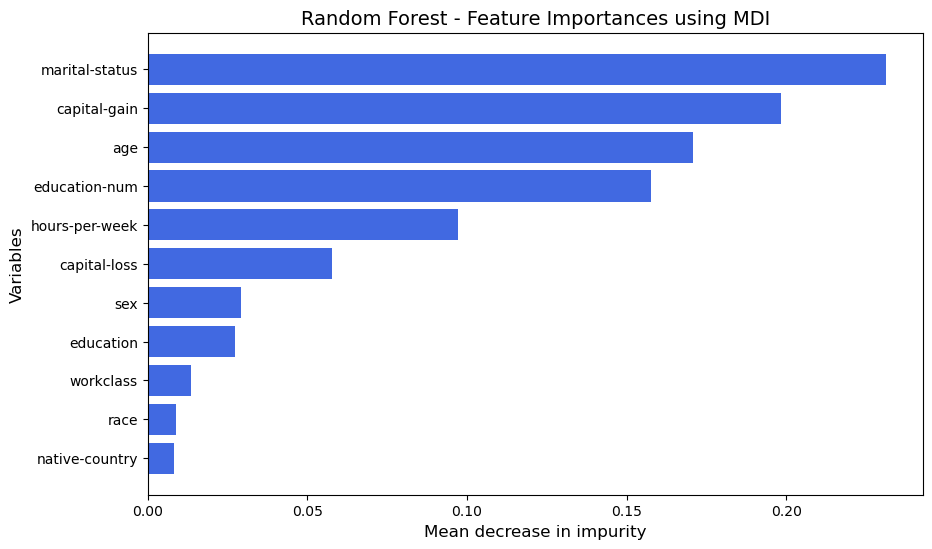

In [390]:
clf2.fit(X_train,y_train)
importances_df = pd.DataFrame({
    'Feature':  X_train.columns,
    'Importance': clf2.feature_importances_
})

# Ordinare per importanza decrescente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='royalblue')
plt.gca().invert_yaxis()  # Invertire l'asse Y per avere la variabile più importante in alto
plt.title('Random Forest - Feature Importances using MDI', fontsize=14)
plt.xlabel('Mean decrease in impurity', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.show()

In [422]:
X_train.head()

,age,workclass,education,education-num,marital-status,race,sex,capital-gain,capital-loss,hours-per-week,native-country
10908,64,1,1,10,0,1,0,0,0,40,1
29515,40,1,0,9,1,1,1,0,0,40,1
6477,36,1,0,9,1,1,1,0,0,33,1
9288,33,0,0,9,1,1,1,0,0,40,1
17140,48,1,1,10,0,1,0,0,1590,38,1


In [476]:
# Create a DataFrame for the new data:
# 50 enne, settore privato, senza laurea nè college, 11 anni di studi, sposato, bianco, uomo, 1000 gain, 0 loss, 35 ore settimanali, non-nativo
Xnew = pd.DataFrame([[50, 1, 0, 11, 1, 1, 1, 1000, 0,35, 0]],
                     columns=X_train.columns)

# Predict the label for the new data
ynew = pipeline.predict(Xnew)
print(ynew) # classificato come 0, cioè stipendio inferiore a 50K

[0]
